In [14]:
import functools
import jax
import jax.numpy as jnp
from jax.tree_util import Partial

from liesel_sparse import band

jax.config.update("jax_enable_x64", True)


### Kernels


def RBFKernel(sigma_f, length, x, y):
    return (
            sigma_f * jnp.exp(-(jnp.linalg.norm(x - y) ** 2) / (2 * length ** 2))
    ).astype(float)


def ExpSineSquaredKernel(sigma_f, length, periodictiy, x, y):
    return (
            sigma_f
            * jnp.exp(
        -2 * (jnp.sin(jnp.pi * jnp.linalg.norm(x - y) / periodictiy) / length) ** 2
    )
    ).astype(float)


def MaternKernel32(sigma_f, length_scale, x, y):
    arg = jnp.sqrt(3) * jnp.linalg.norm(x - y) / length_scale
    return (sigma_f * (1 + arg) * jnp.exp(-arg)).astype(float)


def MaternKernel52(sigma_f, length_scale, x, y):
    arg = jnp.sqrt(5) * jnp.linalg.norm(x - y) / length_scale
    return (sigma_f * (1 + arg + jnp.square(arg) / 3) * jnp.exp(-arg)).astype(float)


def ABDKernel(sigma_f, length_scale, x, y):
    return sigma_f * jnp.exp(
        -jnp.linalg.norm(x / length_scale - y / length_scale)
    ).astype(float)


### Implementation


@jax.jit
def cov_matrix(x1, x2, cov_function):
    # Returns the symmetric kernel matrix K.
    return jax.vmap(lambda x_: jax.vmap(lambda y_: cov_function(x_, y_))(x1))(x2)


@functools.partial(jax.jit, static_argnames=["kernel_"])
def log_likelihood(kernel_, params, data_x, data_y, eps):
    # Compute the negative marginal log likelihood.
    Lb, alpha = inv_cov_chol(Partial(kernel_, *params), data_x, data_y, eps)

    return -(
            -0.5 * jnp.dot(data_y, alpha)
            - (jnp.log(Lb[0])).sum()
            - 0.5 * alpha.shape[0] * jnp.log(2 * jnp.pi)
    )


@jax.jit
def inv_cov_chol(cov_f, data_x, data_y, eps):
    # Get Kernel and add noise.
    K = cov_matrix(data_x, data_x, cov_f)
    Kb = band.to_band(K, K.shape[0])
    Kb = Kb.at[0].add(eps)
    #K = K.at[jnp.diag_indices_from(K)].add(eps)

    # Solve Kα=y using the Cholesky decomposition.
    #L = jax.lax.linalg.cholesky(K)
    Lb = band.cholesky_band(Kb)
    alpha = band.solve_band(Lb, data_y)
    #alpha = jax.lax.linalg.triangular_solve(
    #    L.T,
    #    jax.lax.linalg.triangular_solve(L, data_y, left_side=True, lower=True),
    #    left_side=True,
    #)

    return Lb, alpha


class GPR:
    def __init__(self, data_x, data_y, kernel_, params, eps=1e-10):
        self.data_x = data_x
        self.data_y = data_y
        self.kernel_ = kernel_
        self.covariance_function = Partial(kernel_, *params)  # ??
        self.params = params
        self.eps = eps

        self.Lb_ = None
        self.alpha_ = None
        self.log_marginal_likelihood_value_ = log_likelihood(
            self.kernel_, self.params, self.data_x, self.data_y, self.eps
        )

    # Function to predict output at new input values.
    def predict(self, at_values, return_std=False):
        if self.alpha_ is None:
            # Compute values needed for prediction after fit.
            self.Lb_, self.alpha_ = inv_cov_chol(
                self.covariance_function, self.data_x, self.data_y, self.eps
            )

        K_trans = cov_matrix(self.data_x, at_values, self.covariance_function)
        y_mean = K_trans @ self.alpha_

        if return_std:
            V = jax.scipy.linalg.solve_triangular(band.to_ltri_full(self.Lb_), K_trans.T, lower=True)
            y_var = jnp.diag(cov_matrix(at_values, at_values, self.covariance_function))
            y_var -= jnp.einsum("ij,ji->i", V.T, V)
            y_var = y_var.at[jnp.argwhere(y_var < 0)].set(0)

            return y_mean, jnp.sqrt(y_var)
        return y_mean

    # def fit(self):
    #     import optax
    #
    #     def get_update_fn(optimizer):
    #         def update(params, opt_state):
    #             grads = jax.grad(Partial(log_likelihood, self.kernel_))(params, self.data_x, self.data_y)  # ?
    #             updates, opt_state = optimizer.update(grads, opt_state, params=params)
    #             params = optax.apply_updates(params, updates)
    #             return params, opt_state
    #
    #         return jax.jit(update)
    #
    #     optimizer = optax.sgd(learning_rate=3e-3)
    #
    #     params = self.params
    #     opt_state = optimizer.init(params)
    #     update_f = get_update_fn(optimizer)
    #
    #     for j in range(1000):
    #         params, opt_state = update_f(params, opt_state)
    #
    #     self.params = params
    #     self.covariance_function = Partial(self.kernel_, *params)

    def fit(self):
        # Use BFGS for Gradient Descent to optimize mll.
        # Only one (Unbounded) run is performed.
        import jaxopt

        solver = jaxopt.ScipyMinimize(
            fun=Partial(log_likelihood, self.kernel_),
            jit=True,
            # method='BFGS',
            maxiter=1000,
        )
        soln = solver.run(
            self.params, data_x=self.data_x, data_y=self.data_y, eps=self.eps
        )

        params, state = soln
        print(f"Final solve: {state.fun_val} at {params}")
        print(f"State: {state.success=}, {state.status=}, {state.iter_num=}")

        # Precompute quantities required for predictions which are independent
        # of actual query points
        self.params = params
        self.covariance_function = Partial(self.kernel_, *params)
        self.log_marginal_likelihood_value_ = log_likelihood(
            self.kernel_, self.params, self.data_x, self.data_y, self.eps
        )
        self.alpha_ = None

## Compare
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Toy data
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

rng = np.random.RandomState(0)
training_indices = rng.choice(np.arange(y.size), size=15, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

# Observation Noise
noise_std = 1
y_train = y_train + rng.normal(loc=0, scale=noise_std, size=y_train.shape)

# Parameters
s = 3.94
l = 1.09
p = 5.43e+04

theta_init = jnp.array([s, l, p], dtype=float)

41.28852919707108 at 1.98**2 * Matern(length_scale=1.09, nu=2.5)
---
41.28852919707108


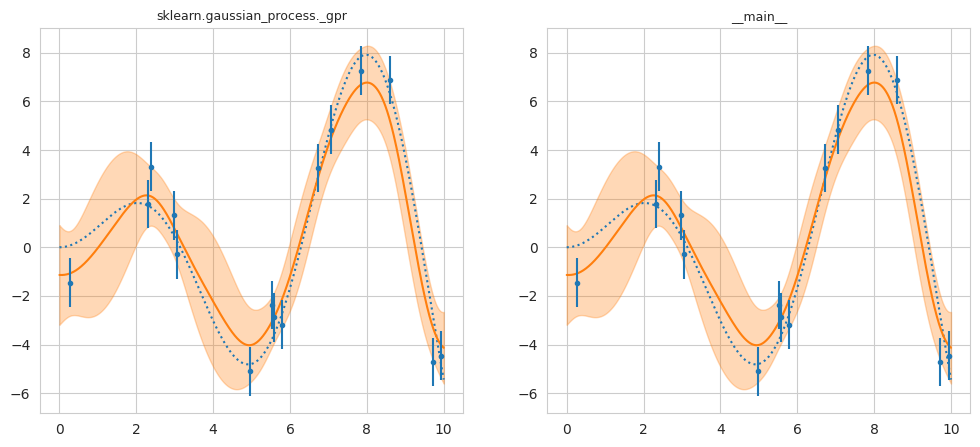

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        kernel = s * Matern(l, nu=2.5)
        gaussian_process = GaussianProcessRegressor(
            kernel=kernel,
            alpha=noise_std ** 2, optimizer=None
        )
        gaussian_process.fit(X_train, y_train)
        print(-gaussian_process.log_marginal_likelihood_value_, "at", gaussian_process.kernel_)
        print("---")
    else:
        def kernel(s1, l1, p1, x, y):
            return MaternKernel52(s1, l1, x, y)

        gaussian_process = GPR(X_train, y_train, kernel, theta_init, eps=noise_std ** 2)
        if hasattr(gaussian_process, "log_marginal_likelihood_value_"):
            print(gaussian_process.log_marginal_likelihood_value_)
        #gaussian_process.fit()

    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    ax.plot(X, y, linestyle="dotted")
    ax.plot(X, mean_prediction, label="Mean prediction")
    ax.errorbar(
        X_train,
        y_train,
        noise_std,
        linestyle="None",
        color="tab:blue",
        marker=".",
        label="Observations",
    )
    ax.fill_between(
        X.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.3,
        color="tab:orange",
    )
    ax.set_title(gaussian_process.__module__, fontsize=9)
plt.show()

# Band